<img src='img/logo.png' width=200>
<center>
    <br/>
    Otkrivanje zakonitosti u podacima 2021-2022
    <br/>
    Fakultet Organizacionih Nauka, 2021
    <br/>
    <h1>D1. Domaći zadatak 1</h1>
</center>

<center>
    <h1>Tim 404! </h1>
</center>

## Zahtevi domaćeg zadatka

1. Učitati i spojiti podatke
    1. Učitati podatke o transakcijama računa (folder `data` fajl `trans.csv`).
    2. Učitati podatke o korisnicima i povezati sa transakcijama (folder `data` fajl `client_accounts.csv`).
    3. Izračunati broj različitih računa koje korisnik poseduje.
    4. Napraviti pivot tabelu sume iznosa po tipu transakcije za svakog klijenta.
    5. Napraviti pivot tabelu sume iznosa po operaciji za svakog klijenta.
    6. Popuniti nedostajuće podatke.
    7. Rezultate iz C, D i E spojiti u jedan skup podataka nad kojim će se raditi klasterovanje od koraka 3.
2. RFM task
    1. Koristiti podatke o transakcijama računa (folder `data` fajl `trans.csv`) i povezati skup podataka sa podacima o korisnicima.
    2. Podeliti klijente (kolonu `client_id`) u 5 grupa i koristeći rfm_group_mapping funkciju (predavanja Segmentacija korisnika).
    3. Recency da se računa kao broj dana od 10.05.2019. godine.
    4. Frequency kao broj transakcija.
    5. Monetary kao prosečna vrednost transakcije.
    6. Prikazati prosečne vrednosti RFM kategorija po svakog grupi.
3. Normalizovati podatke na dva načina po izboru (npr. MaxMin, StandardScaler ili Normalizer). Za svaki od setova normalizovanih podataka uraditi sledeće:
    1. Identifikovati ekstremne vrednosti, karakterisati ih (zašto su ekstremne) i izbaciti iz skupa.
    2. Optimizovati K-means model po broju klastera koristeći SSE i Silhouette (dva optimizovana modela treba dobiti za svaku normalizaciju - ukupno četiri).
    3. Prikazati centroide na osnovu linijskog grafa, 
    4. Opisati svaki klaster u nekoliko rečenica (zapisati u Notebook-u).
    5. Odgovoriti na pitanje koji klaster model je prema vašem mišljenju bolji (optimizovan na osnovu na siluet indeksa ili SSE) i zašto.
4. Kreirati hijerarhijski model klasterovanja.
    1. Prikazati denrogram.
    2. Odrediti granicu preseka na osnovu dendrograma i kreirati klastere (opisati klastere u Notebook-u i opisati zašto ste izabrali baš taj broj klastera).

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import datetime
from datetime import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from yellowbrick.cluster import SilhouetteVisualizer
from scipy.cluster.hierarchy import dendrogram, linkage
import math
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
from sklearn.preprocessing import StandardScaler

# 1. Učitavanje, spajanje i priprema podataka 


Prvi korak ka daljem radu i analizi je učitavanje podataka o transakcijama i klijentima.

In [2]:
trans1= pd.read_csv('data/trans.csv')
client= pd.read_csv('data/client_accounts.csv')

## Pregled skupa podataka o transakcijama

Kako bi bolje sagledali podatke o transakcijama i uvideli neke moguće nedostatke, neophodno je putem par komandi ispitati tip podataka, vrednosti podataka, deskriptivnu statistiku i slično.

In [3]:
f'Broj kolona: {len(trans1.columns)}, broj redova: {len(trans1)}'

'Broj kolona: 10, broj redova: 1056320'

Skup podataka o transakcijama ima **10** različitih atributa i **1.056.320** rekorda. Može se zaključiti da se radi o jako velikom broju podataka.

In [4]:
trans1.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,695247,2378,2017-09-10 03:24:33,INCOME,DEPOSIT,700.0,700.0,NaN,NaN,NaN
1,171812,576,2017-09-14 03:24:33,INCOME,DEPOSIT,900.0,900.0,NaN,NaN,NaN
2,207264,704,2017-09-21 03:24:33,INCOME,DEPOSIT,1000.0,1000.0,NaN,NaN,NaN
3,1117247,3818,2017-09-06 03:24:33,INCOME,DEPOSIT,600.0,600.0,NaN,NaN,NaN
4,579373,1972,2017-09-19 03:41:13,INCOME,DEPOSIT,400.0,400.0,NaN,NaN,NaN


In [5]:
trans1.tail()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
1056315,3626622,2906,2019-04-25 21:11:13,INCOME,NaN,62.3,13729.4,UROK,NaN,NaN
1056316,3627616,2935,2019-04-27 21:11:13,INCOME,NaN,81.3,19544.9,UROK,NaN,NaN
1056317,3625403,2869,2019-05-09 21:11:13,INCOME,NaN,60.2,14638.2,UROK,NaN,NaN
1056318,3626683,2907,2019-04-24 21:11:13,INCOME,NaN,107.5,23453.0,UROK,NaN,NaN
1056319,3626540,2902,2019-05-03 21:11:13,INCOME,NaN,164.1,41642.9,UROK,NaN,NaN


Sledi vizuelni prikaz kolone  *type*. 

EXPENDITURE    634571
INCOME         405083
CHOICE          16666
Name: type, dtype: int64


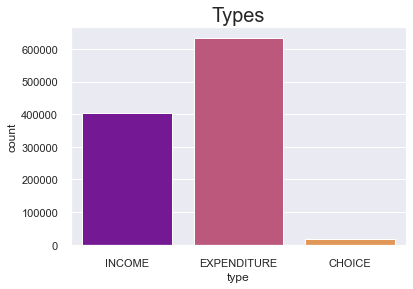

In [6]:
sb.countplot(trans1['type'], palette='plasma').set_title('Types', fontsize=20)
print(trans1['type'].value_counts())

Može se zaključiti da najviše transakcija pripada tipu *expenditure*, zatim drugi po veličini je tip *income* i na kraju sa najmanjim brojem vrednosti je tip *choice*. Takođe, može se reći da najviše ima onih transakcija koje predstavljaju neku vrstu rashoda.

Sledi prikaz atributa *operation*:

In [7]:
print(trans1['operation'].value_counts())

CHOICE                   434918
ACCOUNT TRANSFER         208283
DEPOSIT                  156743
TRANSFER FROM ACCOUNT     65226
CARD                       8036
Name: operation, dtype: int64


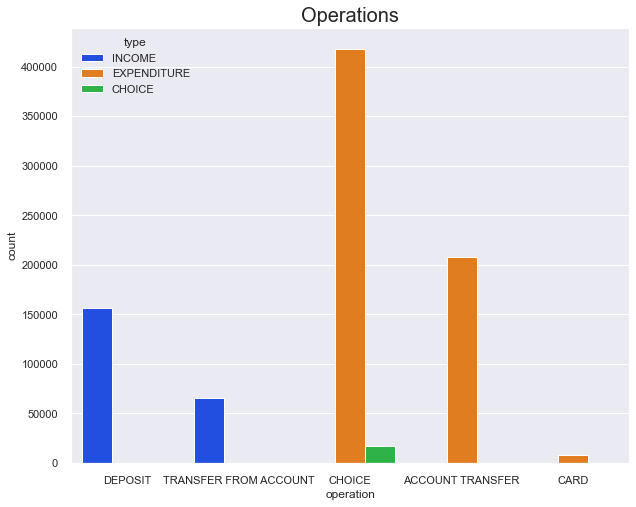

In [8]:
plt.figure(figsize=(10, 8))
sb.countplot(trans1['operation'], palette='bright', hue=trans1['type']).set_title('Operations', fontsize=20)
plt.show()

Kod ovog atributa se jasno može vdeti da je najveći broj transakcija izvršen preko operacije choice, a najmanji preko operacije card. Takođe, za svaku od operacija se može videti kom tipu pripada.

UROK           183114
SLUZBY         155832
SIPO           118065
                53433
DUCHOD          30338
POJISTNE        18500
UVER            13580
SANKC. UROK      1577
Name: k_symbol, dtype: int64


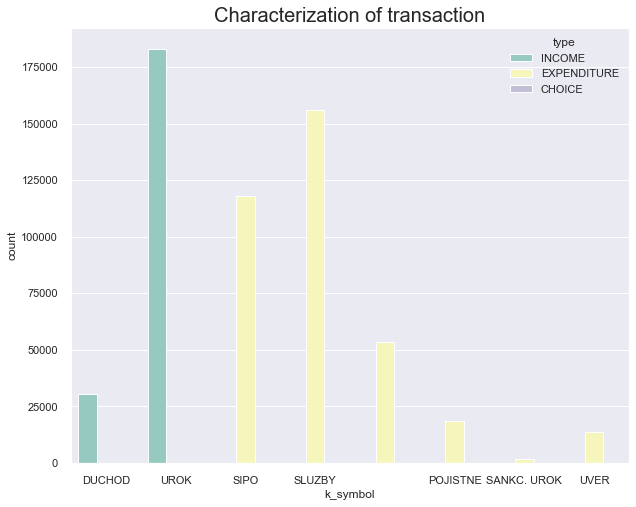

In [9]:
plt.figure(figsize=(10, 8))
sb.countplot(trans1['k_symbol'], palette='Set3', hue=trans1['type']).set_title('Characterization of transaction', fontsize=20)
print(trans1['k_symbol'].value_counts())

Vrednosti za atribut *k_symbol*:
- POJISTNE = Insurance Payment (IP) - Plaćanje osiguranja

- SLUZBY = Payment on Statement (PS) - Plaćanje po izvodu

- UROK = Interest Credited (ICR) - Pripisane kamate

- SANKC. UROK - Sanction Interest (SI) - Sankciona kamata

- SIPO - Household (H) - Domaćinstvo

- DUCHOD - Old-age Pension (OP) - Starosna Penzija

- UVER - Loan Payment (LP) - Otplata kredita

In [10]:
trans1.dtypes

trans_id        int64
account_id      int64
date           object
type           object
operation      object
amount        float64
balance       float64
k_symbol       object
bank           object
account       float64
dtype: object

Kako je tip podataka za atribut date *object*, potrebno ga je promeniti u tip *date time*.

In [11]:
trans1['date'] = pd.to_datetime(trans1['date'])
trans1.dtypes

trans_id               int64
account_id             int64
date          datetime64[ns]
type                  object
operation             object
amount               float64
balance              float64
k_symbol              object
bank                  object
account              float64
dtype: object

In [12]:
trans1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056320 entries, 0 to 1056319
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   trans_id    1056320 non-null  int64         
 1   account_id  1056320 non-null  int64         
 2   date        1056320 non-null  datetime64[ns]
 3   type        1056320 non-null  object        
 4   operation   873206 non-null   object        
 5   amount      1056320 non-null  float64       
 6   balance     1056320 non-null  float64       
 7   k_symbol    574439 non-null   object        
 8   bank        273508 non-null   object        
 9   account     295389 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 80.6+ MB


Iz prethodnog se može videti da neki od atributa imaju i nedostajuće vrednosti, o čemu će kasnije biti više reči.

In [13]:
trans1[['amount','balance']].describe().round(2)

,amount,balance
count,1056320.00,1056320.00
mean,5924.15,38518.33
std,9522.74,22117.87
min,0.00,-41125.70
25%,135.90,22402.50
50%,2100.00,33143.40
75%,6800.00,49603.62
max,87400.00,209637.00


Kako je reč o Češkoj banci, može se pretpostaviti da je valuta u kojoj su izražene vrednosti Češka Kruna. Na slici se može videti kurs dinara izražen u Češkoj kruni.
<img src='img/valuta.png' width=200>
Na osnovu deskriptivne statistike, takođe se može videti da za oba atributa je vrednost medijana manja od srednje vrednosti, što je karakterističan primer *positive skew* raspodele, gde ima veći broj manjih vrednosti, a manji broj velikih vrednosti. Na slici ispod se može videti histogram za ove dva atributa.

array([[<AxesSubplot:title={'center':'amount'}>,
        <AxesSubplot:title={'center':'balance'}>]], dtype=object)

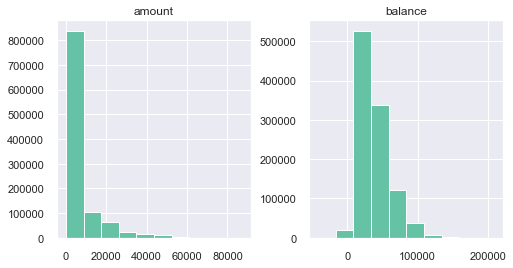

In [14]:
sb.set_palette(palette='Set2')
trans1[['amount','balance']].hist(bins=10, figsize=(8, 4))

In [15]:
obj_dt = trans1.select_dtypes(include=['object', 'datetime'])
obj_dt.describe()

,date,type,operation,k_symbol,bank
count,1056320,1056320,873206,574439,273508
unique,41784,3,5,8,13
top,2019-04-15 11:11:13,EXPENDITURE,CHOICE,UROK,QR
freq,516,634571,434918,183114,22285
first,2017-09-06 03:24:33,NaN,NaN,NaN,NaN
last,2019-05-09 21:11:13,NaN,NaN,NaN,NaN


In [16]:
trans1.isna().sum()

trans_id           0
account_id         0
date               0
type               0
operation     183114
amount             0
balance            0
k_symbol      481881
bank          782812
account       760931
dtype: int64

Nedostajuće vrednosti izražene u procentima po atributima za koje su identifikovane ovakve vrednosti:

- operation: **17.33%**
- k_symbol: **45.5%**
- bank: **74.10**
- account: **72.03**

### Regulisanje nedostajućih vrednosti

U prethodnom delu je utvrđeno da postoje nedostajuće vrednosti. Sada ih je potrebno popuniti.

In [17]:
trans1['operation'].fillna('OPERATION UNKNOWN', inplace= True)
trans1['operation'].value_counts(normalize=True)

CHOICE                   0.411729
ACCOUNT TRANSFER         0.197178
OPERATION UNKNOWN        0.173351
DEPOSIT                  0.148386
TRANSFER FROM ACCOUNT    0.061748
CARD                     0.007608
Name: operation, dtype: float64

In [18]:
trans1['k_symbol'].fillna('K_SYMBOL UNKNOWN', inplace= True)
trans1['k_symbol'].value_counts(normalize=True)

K_SYMBOL UNKNOWN    0.456188
UROK                0.173351
SLUZBY              0.147523
SIPO                0.111770
                    0.050584
DUCHOD              0.028720
POJISTNE            0.017514
UVER                0.012856
SANKC. UROK         0.001493
Name: k_symbol, dtype: float64

In [19]:
trans1.loc[(trans1['k_symbol'] == '') | (trans1['k_symbol'] == ' '), 'k_symbol'] = 'K_SYMBOL UNKNOWN'
trans1['k_symbol'].value_counts(normalize=True)

K_SYMBOL UNKNOWN    0.506773
UROK                0.173351
SLUZBY              0.147523
SIPO                0.111770
DUCHOD              0.028720
POJISTNE            0.017514
UVER                0.012856
SANKC. UROK         0.001493
Name: k_symbol, dtype: float64

In [20]:
trans1['bank'].fillna('BANK UNKNOWN', inplace= True)
trans1['bank'].value_counts(normalize=True)

BANK UNKNOWN    0.741075
QR              0.021097
AB              0.020562
ST              0.020553
YZ              0.020431
GH              0.020353
EF              0.020158
KL              0.020102
UV              0.020038
OP              0.019969
IJ              0.019431
WX              0.019102
MN              0.018577
CD              0.018552
Name: bank, dtype: float64

In [21]:
trans1['account'].fillna('ACCOUNT UNKNOWN', inplace= True)
trans1['account'].value_counts(normalize=True)

ACCOUNT UNKNOWN    7.203603e-01
0.0                2.071437e-02
66487163.0         1.325356e-04
13943797.0         1.230688e-04
95437645.0         8.993487e-05
                       ...     
78677373.0         9.466828e-07
54632151.0         9.466828e-07
5624032.0          9.466828e-07
58251345.0         9.466828e-07
74396675.0         9.466828e-07
Name: account, Length: 7666, dtype: float64

In [22]:
trans1.loc[trans1['account'] == 0.0, 'account']='ACCOUNT UNKNOWN'
trans1['account'].value_counts(normalize=True)

ACCOUNT UNKNOWN    7.410747e-01
66487163.0         1.325356e-04
13943797.0         1.230688e-04
95437645.0         8.993487e-05
69415771.0         8.898819e-05
                       ...     
78677373.0         9.466828e-07
54632151.0         9.466828e-07
5624032.0          9.466828e-07
58251345.0         9.466828e-07
74396675.0         9.466828e-07
Name: account, Length: 7665, dtype: float64

In [23]:
trans1.isna().sum()

trans_id      0
account_id    0
date          0
type          0
operation     0
amount        0
balance       0
k_symbol      0
bank          0
account       0
dtype: int64

## Pregled skupa podataka o klijentima

In [24]:
f'Broj kolona: {len(client.columns)}, broj redova: {len(client)}'

'Broj kolona: 2, broj redova: 5369'

In [25]:
client.head()

,account_id,client_id
0,1,1
1,2,2
2,3,2
3,4,3
4,5,3


In [26]:
client.tail()

,account_id,client_id
5364,13955,11349
5365,13956,11349
5366,13968,11359
5367,13971,11362
5368,13998,11382


In [27]:
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   account_id  5369 non-null   int64
 1   client_id   5369 non-null   int64
dtypes: int64(2)
memory usage: 84.0 KB


In [28]:
client.dtypes

account_id    int64
client_id     int64
dtype: object

U skupu podataka o klijentima nema nnedostajućih vrednosti. Oba atributa predstavljaju ključeve.

### Spajanje skupa podataka o transakcijama i korisnicima

In [29]:
trans= trans1.merge(client, left_on='account_id', right_on='account_id', how='inner', indicator=True)
trans.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account,client_id,_merge
0,695247,2378,2017-09-10 03:24:33,INCOME,DEPOSIT,700.0,700.0,K_SYMBOL UNKNOWN,BANK UNKNOWN,ACCOUNT UNKNOWN,1956,both
1,695250,2378,2017-09-20 09:14:33,INCOME,DEPOSIT,7268.0,7968.0,K_SYMBOL UNKNOWN,BANK UNKNOWN,ACCOUNT UNKNOWN,1956,both
2,695266,2378,2017-09-14 09:31:13,INCOME,DEPOSIT,14440.0,22408.0,K_SYMBOL UNKNOWN,BANK UNKNOWN,ACCOUNT UNKNOWN,1956,both
3,695262,2378,2017-09-24 09:47:53,INCOME,DEPOSIT,49752.0,72160.0,K_SYMBOL UNKNOWN,BANK UNKNOWN,ACCOUNT UNKNOWN,1956,both
4,695265,2378,2017-09-11 10:21:13,INCOME,DEPOSIT,21899.0,94059.0,K_SYMBOL UNKNOWN,BANK UNKNOWN,ACCOUNT UNKNOWN,1956,both


In [30]:
f'Broj kolona: {len(trans.columns)}, broj redova: {len(trans)}'

'Broj kolona: 12, broj redova: 877282'

### Broj različitih računa koje korisnik poseduje

In [31]:
num_account = trans.groupby(['client_id'])['account_id'].agg('nunique')
num_account.reset_index()

,client_id,account_id
0,1,1
1,2,2
2,3,2
3,4,1
4,5,1
...,...,...
3234,9031,1
3235,9156,1
3236,9199,1
3237,9225,1


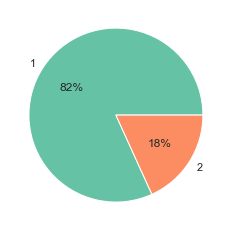

In [32]:
plt.pie(num_account.value_counts(),
        labels=num_account.value_counts().index,
        autopct='%.0f%%')
plt.show()

### Pivot tabela sume iznosa po tipu transakcije za svakog klijenta

In [33]:
p1 = trans.pivot_table(index=['type','client_id'], values= ['amount'], aggfunc=sum)
p1=p1.unstack(level=0,fill_value=0)
p1=p1.reset_index()
p1.columns=['_'.join(i) for i in p1.columns]
p1

,client_id_,amount_CHOICE,amount_EXPENDITURE,amount_INCOME
0,1,0.0,180854.0,194320.5
1,2,217442.0,1458946.6,1770112.5
2,3,0.0,228021.8,289831.0
3,4,0.0,299949.6,347617.5
4,5,0.0,561772.0,630267.9
...,...,...,...,...
3234,9031,209315.0,313253.0,521032.7
3235,9156,13379.0,499493.3,532555.5
3236,9199,0.0,241264.4,318617.2
3237,9225,29529.0,1406911.2,1511641.2


array([[<AxesSubplot:title={'center':'amount_CHOICE'}>,
        <AxesSubplot:title={'center':'amount_EXPENDITURE'}>],
       [<AxesSubplot:title={'center':'amount_INCOME'}>, <AxesSubplot:>]],
      dtype=object)

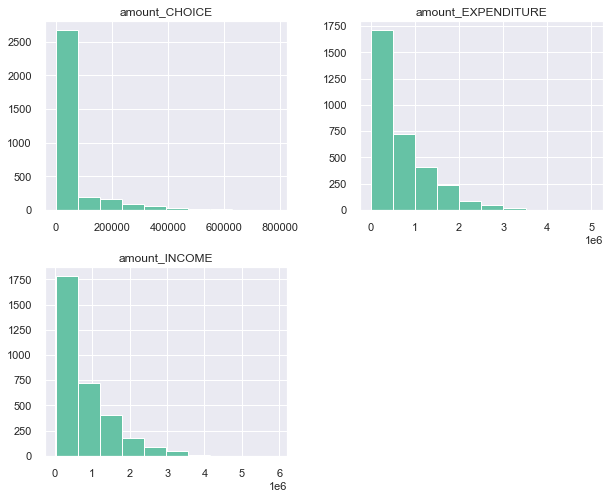

In [34]:
p1[['amount_CHOICE', 'amount_EXPENDITURE', 'amount_INCOME']].hist(figsize=(10, 8))

### Pivot tabela sume iznosa po operaciji za svakog klijenta

In [35]:
p2 = trans.pivot_table(index=['operation','client_id'], values= ['amount'], aggfunc=sum)
p2=p2.unstack(level=0,fill_value=0)
p2=p2.reset_index()
p2.columns=['_'.join(i) for i in p2.columns]
p2

,client_id_,amount_ACCOUNT TRANSFER,amount_CARD,amount_CHOICE,amount_DEPOSIT,amount_OPERATION UNKNOWN,amount_TRANSFER FROM ACCOUNT
0,1,98080.0,0.0,82774.0,25700.0,3065.5,165555.0
1,2,618247.8,0.0,1058140.8,219389.0,12787.5,1537936.0
2,3,136164.0,0.0,91857.8,1400.0,4306.0,284125.0
3,4,185838.0,0.0,114111.6,900.0,6598.5,340119.0
4,5,97600.0,5900.0,458272.0,623775.0,6492.9,0.0
...,...,...,...,...,...,...,...
3234,9031,0.0,0.0,522568.0,516723.0,4309.7,0.0
3235,9156,347096.9,0.0,165775.4,52300.0,3320.5,476935.0
3236,9199,38133.0,0.0,203131.4,315374.0,3243.2,0.0
3237,9225,273539.6,57400.0,1105500.6,4000.0,8364.2,1499277.0


array([[<AxesSubplot:title={'center':'amount_ACCOUNT TRANSFER'}>,
        <AxesSubplot:title={'center':'amount_CARD'}>],
       [<AxesSubplot:title={'center':'amount_CHOICE'}>,
        <AxesSubplot:title={'center':'amount_DEPOSIT'}>],
       [<AxesSubplot:title={'center':'amount_OPERATION UNKNOWN'}>,
        <AxesSubplot:title={'center':'amount_TRANSFER FROM ACCOUNT'}>]],
      dtype=object)

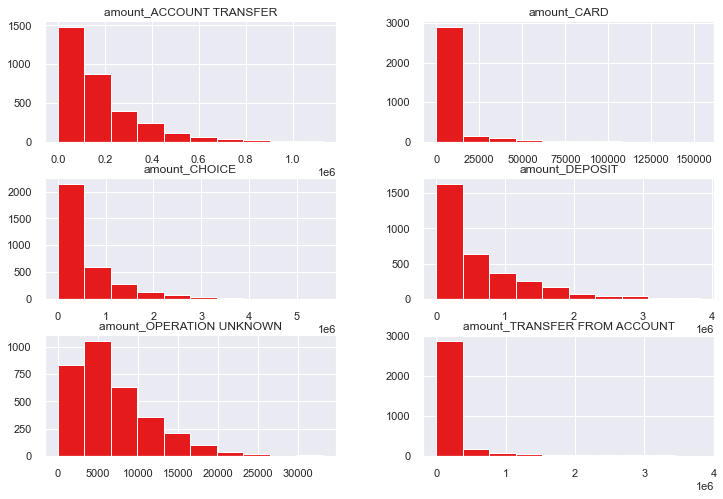

In [36]:
sb.set_palette(palette='Set1')
p2.iloc[:, 1:].hist(figsize=(12, 8))

Pivot tabele sume iznosa za svakog klijenta i po tipu i po operaciji su prethodno i vizuelno prikazane, a sa histograma možemo videti da je reč o prethodno pomenutoj *positive skew* raspodeli.

### Rezultate iz prethodne tri stavke je potrebno spojiti u jedan skup podataka nad kojim će se raditi klasterovanje

In [37]:
num_account=num_account.reset_index()
pivot_type = p1.reset_index()
pivot_operation= p2.reset_index()

Prvo su spojene prethodno kreirane pivot tabele, a zatim i dobijeni skup podataka sa podacima o broju različitih računa po klijentima.

In [38]:
merge_1 = pivot_type.merge(pivot_operation, left_on='client_id_', right_on='client_id_', how='outer', indicator=True)
df = num_account.merge(merge_1, left_on='client_id', right_on='client_id_', how='inner', indicator='_merge2')

S obzirom na to da će se dobijeni skup podataka koristiti za klaster analizu, promenjeni su nayivi kolona radi lakšeg snalaženja.

In [39]:
df=df.rename(columns= {'account_id': 'num_dist_account', 'amount_CHOICE_x': 'choice_type', 'amount_EXPENDITURE' : 'expenditure_type', 'amount_OPERATION UNKNOWN':'operation_unknown'})
df=df.rename(columns= {'amount_INCOME': 'income_type', 'amount_ACCOUNT TRANSFER': 'account_transfer_operation', 'amount_CARD' : 'card_operation'})
df=df.rename(columns= {'amount_CHOICE_y': 'choice_operation', 'amount_DEPOSIT': 'deposit_operation', 'amount_TRANSFER FROM ACCOUNT' : 'transfer_from_account_operation'})
df=df.drop(columns=['client_id_', 'index_x', 'index_y', '_merge', '_merge2'], axis=1)
df

,client_id,num_dist_account,choice_type,expenditure_type,income_type,account_transfer_operation,card_operation,choice_operation,deposit_operation,operation_unknown,transfer_from_account_operation
0,1,1,0.0,180854.0,194320.5,98080.0,0.0,82774.0,25700.0,3065.5,165555.0
1,2,2,217442.0,1458946.6,1770112.5,618247.8,0.0,1058140.8,219389.0,12787.5,1537936.0
2,3,2,0.0,228021.8,289831.0,136164.0,0.0,91857.8,1400.0,4306.0,284125.0
3,4,1,0.0,299949.6,347617.5,185838.0,0.0,114111.6,900.0,6598.5,340119.0
4,5,1,0.0,561772.0,630267.9,97600.0,5900.0,458272.0,623775.0,6492.9,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3234,9031,1,209315.0,313253.0,521032.7,0.0,0.0,522568.0,516723.0,4309.7,0.0
3235,9156,1,13379.0,499493.3,532555.5,347096.9,0.0,165775.4,52300.0,3320.5,476935.0
3236,9199,1,0.0,241264.4,318617.2,38133.0,0.0,203131.4,315374.0,3243.2,0.0
3237,9225,1,29529.0,1406911.2,1511641.2,273539.6,57400.0,1105500.6,4000.0,8364.2,1499277.0


Ovaj skup podataka je sačuvan kao .csv fajl u folderu data.

In [40]:
#df.to_csv('data/cluster.csv')

# 2. RFM model

Kako bi se sagledalo ponašanje klijenata prilikom vršenja bankovnih transakcija, najbolje je koristiti *RFM* model za analizu, a koji prati vrednosti tri atributa: period koji je protekao od poslednje izvršene transakcije, učestalost transakcija i prosečna vrenost iznosa u transakcijama.

Neki delovi koda će biti ponovljeni, jer u određenim delovima je dolazilo do promene na osnovu zahteva zadatka. 

In [41]:
trans1= pd.read_csv('data/trans.csv')
client= pd.read_csv('data/client_accounts.csv')
trans1['date'] = pd.to_datetime(trans1['date'])
trans1['account']=trans1['account'].astype('object')
trans1['operation'].fillna('OPERATION UNKNOWN', inplace= True)
trans1['k_symbol'].fillna('K_SYMBOL UNKNOWN', inplace= True)
trans1.loc[(trans1['k_symbol'] == '') | (trans1['k_symbol'] == ' '), 'k_symbol'] = 'K_SYMBOL UNKNOWN'
trans1['bank'].fillna('BANK UNKNOWN', inplace= True)
trans1['account'].fillna('ACCOUNT UNKNOWN', inplace= True)
trans1.loc[trans1['account'] == 0.0, 'account']='ACCOUNT UNKNOWN'
trans= trans1.merge(client, left_on='account_id', right_on='account_id', how='inner', indicator=True)

In [42]:
trans.tail()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account,client_id,_merge
877277,961562,3276,2019-04-20 14:14:33,INCOME,DEPOSIT,8254.5,48138.3,K_SYMBOL UNKNOWN,BANK UNKNOWN,ACCOUNT UNKNOWN,2714,both
877278,961610,3276,2019-05-03 14:47:53,EXPENDITURE,ACCOUNT TRANSFER,929.0,43567.3,K_SYMBOL UNKNOWN,CD,4509616.0,2714,both
877279,961640,3276,2019-04-22 14:47:53,EXPENDITURE,CHOICE,1920.0,44496.3,K_SYMBOL UNKNOWN,BANK UNKNOWN,ACCOUNT UNKNOWN,2714,both
877280,961634,3276,2019-04-20 16:11:13,EXPENDITURE,ACCOUNT TRANSFER,1017.0,42550.3,POJISTNE,WX,88365083.0,2714,both
877281,3639005,3276,2019-05-06 21:11:13,INCOME,OPERATION UNKNOWN,177.1,42727.4,UROK,BANK UNKNOWN,ACCOUNT UNKNOWN,2714,both


Za kreiranje kolona R, F i M koristimo sledeće atribute:

- date
- trans_id
- amount

In [43]:
rfm= trans.groupby('client_id').agg({'date':'max', 'trans_id':'count', 'amount':'sum'})
rfm.head()

,date,trans_id,amount
client_id,,,
1,2019-05-08 13:57:53,239,375174.5
2,2019-05-09 16:44:33,595,3446501.1
3,2019-05-08 14:37:53,270,517852.8
4,2019-05-06 15:37:53,246,647567.1
5,2019-05-05 14:14:33,130,1192039.9


Kolonu *Monetary* se dobija kada se podeli suma iznosa sa brojem transakcija.

In [44]:
rfm['amount-avg'] = (rfm['amount']/rfm['trans_id']).round(2)
rfm

,date,trans_id,amount,amount-avg
client_id,,,,
1,2019-05-08 13:57:53,239,375174.5,1569.77
2,2019-05-09 16:44:33,595,3446501.1,5792.44
3,2019-05-08 14:37:53,270,517852.8,1917.97
4,2019-05-06 15:37:53,246,647567.1,2632.39
5,2019-05-05 14:14:33,130,1192039.9,9169.54
...,...,...,...,...
9031,2019-05-08 17:07:53,146,1043600.7,7147.95
9156,2019-05-08 11:17:53,303,1045427.8,3450.26
9199,2019-05-08 15:54:33,75,559881.6,7465.09


Kolonu *Recency* se dobija kada se od datuma 5.10.2019. oduzmu vrednosti maksimalnih datuma kolone *date*.

In [45]:
today = dt.strptime('2019-05-10','%Y-%m-%d')

Period je izražen kao broj **dana** od poslednje transakcije.

In [46]:
rfm['date-recency_'] = rfm['date'].apply(lambda x: (today-pd.to_datetime(x)).total_seconds()/(60*60*24))
rfm.head()

,date,trans_id,amount,amount-avg,date-recency_
client_id,,,,,
1,2019-05-08 13:57:53,239,375174.5,1569.77,1.418137
2,2019-05-09 16:44:33,595,3446501.1,5792.44,0.302396
3,2019-05-08 14:37:53,270,517852.8,1917.97,1.390359
4,2019-05-06 15:37:53,246,647567.1,2632.39,3.348692
5,2019-05-05 14:14:33,130,1192039.9,9169.54,4.406562


U sledećem kodu je regulisana ekstremizacija podataka.

In [47]:
rfm['date-recency']= 1/rfm['date-recency_']
rfm.head()

,date,trans_id,amount,amount-avg,date-recency_,date-recency
client_id,,,,,,
1,2019-05-08 13:57:53,239,375174.5,1569.77,1.418137,0.705151
2,2019-05-09 16:44:33,595,3446501.1,5792.44,0.302396,3.306924
3,2019-05-08 14:37:53,270,517852.8,1917.97,1.390359,0.719239
4,2019-05-06 15:37:53,246,647567.1,2632.39,3.348692,0.298624
5,2019-05-05 14:14:33,130,1192039.9,9169.54,4.406562,0.226934


Da bi se svele vrednosti sve tri kolone na isti opseg, može se koristiti normalizacija, međutim, u marketinškoj analizi se pre koristi skaliranje vrednosti u određeni broj binova.

In [48]:
rfm['Recency'] = pd.qcut(rfm['date-recency'], q=5,  labels= False) + 1
rfm['Frequency'] = pd.qcut(rfm['trans_id'], q=5, labels= False) + 1
rfm['Monetary'] = pd.qcut(rfm['amount-avg'], q=5, labels= False) + 1
rfm.head(100)

,date,trans_id,amount,amount-avg,date-recency_,date-recency,Recency,Frequency,Monetary
client_id,,,,,,,,,
1,2019-05-08 13:57:53,239,375174.5,1569.77,1.418137,0.705151,3,3,1
2,2019-05-09 16:44:33,595,3446501.1,5792.44,0.302396,3.306924,5,5,4
3,2019-05-08 14:37:53,270,517852.8,1917.97,1.390359,0.719239,3,3,1
4,2019-05-06 15:37:53,246,647567.1,2632.39,3.348692,0.298624,1,3,2
5,2019-05-05 14:14:33,130,1192039.9,9169.54,4.406562,0.226934,1,2,5
...,...,...,...,...,...,...,...,...,...
108,2019-05-08 14:47:53,103,275453.8,2674.31,1.383414,0.722849,3,1,2
109,2019-05-08 21:11:13,212,955769.0,4508.34,1.117211,0.895086,4,3,3
110,2019-05-08 21:11:13,198,2535955.1,12807.85,1.117211,0.895086,4,2,5


*RFM Score* se dobija kao proizvod dobijene tri kolone. 

In [49]:
rfm['RFM Score'] = rfm[['Recency', 'Frequency', 'Monetary']].agg('prod', axis=1)
rfm.head()

,date,trans_id,amount,amount-avg,date-recency_,date-recency,Recency,Frequency,Monetary,RFM Score
client_id,,,,,,,,,,
1,2019-05-08 13:57:53,239,375174.5,1569.77,1.418137,0.705151,3,3,1,9
2,2019-05-09 16:44:33,595,3446501.1,5792.44,0.302396,3.306924,5,5,4,100
3,2019-05-08 14:37:53,270,517852.8,1917.97,1.390359,0.719239,3,3,1,9
4,2019-05-06 15:37:53,246,647567.1,2632.39,3.348692,0.298624,1,3,2,6
5,2019-05-05 14:14:33,130,1192039.9,9169.54,4.406562,0.226934,1,2,5,10


Dobijeni skor se potom deli u klastere.

In [50]:
rfm['RFM Cluster'] = pd.cut(rfm['RFM Score'], [0, 1, 8, 27, 64, 125], labels= False) + 1
rfm.head()

,date,trans_id,amount,amount-avg,date-recency_,date-recency,Recency,Frequency,Monetary,RFM Score,RFM Cluster
client_id,,,,,,,,,,,
1,2019-05-08 13:57:53,239,375174.5,1569.77,1.418137,0.705151,3,3,1,9,3
2,2019-05-09 16:44:33,595,3446501.1,5792.44,0.302396,3.306924,5,5,4,100,5
3,2019-05-08 14:37:53,270,517852.8,1917.97,1.390359,0.719239,3,3,1,9,3
4,2019-05-06 15:37:53,246,647567.1,2632.39,3.348692,0.298624,1,3,2,6,2
5,2019-05-05 14:14:33,130,1192039.9,9169.54,4.406562,0.226934,1,2,5,10,3


In [51]:
rfm.groupby('RFM Cluster')[['date-recency_', 'trans_id','amount-avg']].agg(['mean', 'std']).round(3)

date-recency_         trans_id          amount-avg          
                     mean     std     mean      std       mean       std
RFM Cluster                                                             
1                  12.894  38.515   84.441   27.037   1646.745   317.393
2                   3.168   6.244  158.517   97.276   3147.764  2503.634
3                   1.787   1.162  244.968  128.435   5121.041  3649.660
4                   1.152   0.722  348.375  150.054   6952.649  3625.459
5                   0.503   0.444  455.227  135.880   8938.920  3252.859

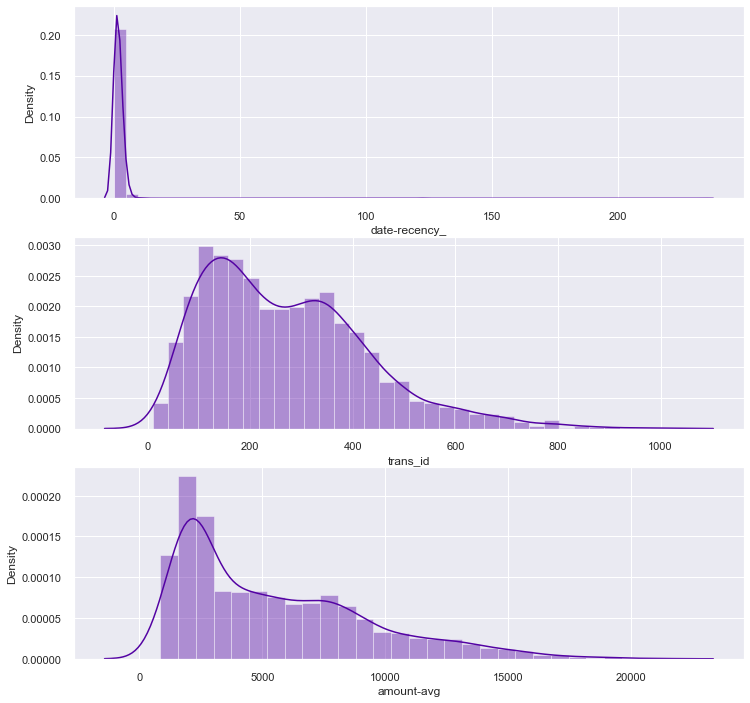

In [52]:
sb.set_palette('plasma')
plt.figure(figsize=(12,12))
plt.subplot(3, 1, 1); sb.distplot(rfm['date-recency_']);
plt.subplot(3, 1, 2); sb.distplot(rfm['trans_id'])
plt.subplot(3, 1, 3); sb.distplot(rfm['amount-avg'])
plt.show()

In [53]:
a=rfm.loc[rfm['date-recency_']<=6, 'date-recency_']
b=rfm.loc[rfm['date-recency_']<=6, 'trans_id']
c=rfm.loc[rfm['date-recency_']<=6, 'amount-avg']

Text(0, 0.5, 'Frequency')

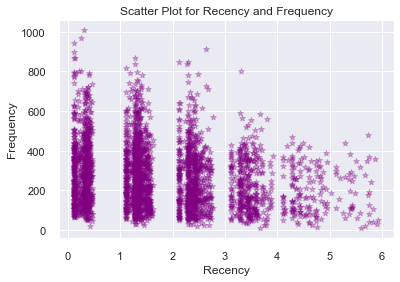

In [54]:

plt.scatter(a, b,
            color = 'purple',
            marker = '*', alpha = 0.3)

plt.title('Scatter Plot for Recency and Frequency') 
plt.xlabel('Recency')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

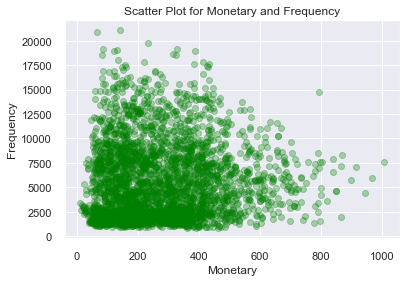

In [55]:
plt.scatter(b,c,
            color = 'green',
            marker = 'o', alpha = 0.3)

plt.title('Scatter Plot for Monetary and Frequency')
plt.xlabel('Monetary')
plt.ylabel('Frequency')

Text(0, 0.5, 'Monetary')

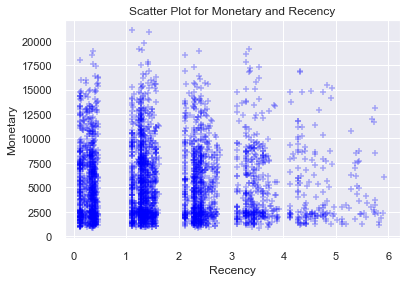

In [56]:
plt.scatter(a, c,
            color = 'blue',
            marker = '+', alpha = 0.3)

plt.title('Scatter Plot for Monetary and Recency')
plt.xlabel('Recency')
plt.ylabel('Monetary')

In [57]:
def rfm_group_mapping(R, F, M):
    if (R == 1) & (1 <= F <= 2) & (M <= 5):
        return 'Fade away'
    elif (R > 1) & (1 <= F <= 3 ) & (1 <= M <= 3):
        return 'Active clients'
    elif (R >= 1) & (1 <= F <=3 ) & (4 <= M <= 5):
        return 'Big spenders'
    elif (R >= 1 ) & (F > 3) & (1 <= M <= 3):
        return 'Loyal clients'
    elif (3 <= R <= 5) & (4 <= F <= 5) & (4 <= M <= 5):
        return 'Number one'
    else: 
        return 'Other'

In [58]:
rfm['RFM Group'] = rfm.apply(lambda x: rfm_group_mapping(x['Recency'], x['Frequency'], x['Monetary']), axis=1)
rfm

,date,trans_id,amount,amount-avg,date-recency_,date-recency,Recency,Frequency,Monetary,RFM Score,RFM Cluster,RFM Group
client_id,,,,,,,,,,,,
1,2019-05-08 13:57:53,239,375174.5,1569.77,1.418137,0.705151,3,3,1,9,3,Active clients
2,2019-05-09 16:44:33,595,3446501.1,5792.44,0.302396,3.306924,5,5,4,100,5,Number one
3,2019-05-08 14:37:53,270,517852.8,1917.97,1.390359,0.719239,3,3,1,9,3,Active clients
4,2019-05-06 15:37:53,246,647567.1,2632.39,3.348692,0.298624,1,3,2,6,2,Other
5,2019-05-05 14:14:33,130,1192039.9,9169.54,4.406562,0.226934,1,2,5,10,3,Fade away
...,...,...,...,...,...,...,...,...,...,...,...,...
9031,2019-05-08 17:07:53,146,1043600.7,7147.95,1.286192,0.777489,3,2,4,24,3,Big spenders
9156,2019-05-08 11:17:53,303,1045427.8,3450.26,1.529248,0.653916,3,4,3,36,4,Loyal clients
9199,2019-05-08 15:54:33,75,559881.6,7465.09,1.337118,0.747877,3,1,4,12,3,Big spenders


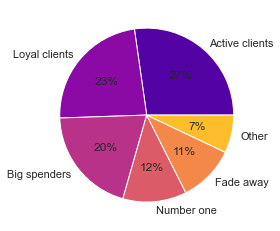

In [59]:
plt.pie(rfm['RFM Group'].value_counts(),
        labels=rfm['RFM Group'].value_counts().index,
        autopct='%.0f%%', )
plt.show()

In [60]:
rfm_group_agg = rfm.groupby('RFM Group').agg({'Recency': 'mean','Frequency': 'mean','Monetary': ['mean', 'count']}).round(1)
print(rfm_group_agg)

               Recency Frequency Monetary      
                  mean      mean     mean count
RFM Group                                      
Active clients     3.4       2.0      1.9   883
Big spenders       3.1       2.1      4.6   649
Fade away          1.0       1.4      2.7   341
Loyal clients      3.0       4.5      2.1   754
Number one         4.0       4.6      4.4   384
Other              1.4       4.0      3.7   228


# K-Means

## Normalizacija podataka upotrebom *MinMaxScaler*-a

Prvi koraj je učitavanje skupa podataka koje smo u prethodnim zahtevima zadataka kreirali i sačuvali.

In [82]:
df=pd.read_csv('data/cluster.csv')
df.drop(columns=['Unnamed: 0','index'],axis=1,inplace=True)
df.head()

,client_id,num_dist_account,choice_type,expenditure_type,income_type,account_transfer_operation,card_operation,choice_operation,deposit_operation,operation_unknown,transfer_from_account_operation
0,1,1,0.0,180854.0,194320.5,98080.0,0.0,82774.0,25700.0,3065.5,165555.0
1,2,2,217442.0,1458946.6,1770112.5,618247.8,0.0,1058140.8,219389.0,12787.5,1537936.0
2,3,2,0.0,228021.8,289831.0,136164.0,0.0,91857.8,1400.0,4306.0,284125.0
3,4,1,0.0,299949.6,347617.5,185838.0,0.0,114111.6,900.0,6598.5,340119.0
4,5,1,0.0,561772.0,630267.9,97600.0,5900.0,458272.0,623775.0,6492.9,0.0


In [83]:
f'Broj kolona: {len(df.columns)}, broj redova: {len(df)}'

'Broj kolona: 11, broj redova: 3239'

Sada je potrebno normalizovati podatke upotrebom *MinMaxScaler* metode.

In [84]:
df_normalized_min_max=MinMaxScaler().fit_transform(df.iloc[:,1:])
df_normalized_min_max=pd.DataFrame(df_normalized_min_max,columns=df.columns[1:])
df_normalized_min_max.head()

,num_dist_account,choice_type,expenditure_type,income_type,account_transfer_operation,card_operation,choice_operation,deposit_operation,operation_unknown,transfer_from_account_operation
0,0.0,0.000000,0.035848,0.029267,0.086932,0.000000,0.014681,0.006638,0.092749,0.043357
1,1.0,0.276449,0.291163,0.296440,0.547975,0.000000,0.190646,0.057059,0.386894,0.402767
2,1.0,0.000000,0.045270,0.045461,0.120687,0.000000,0.016319,0.000312,0.130281,0.074409
3,0.0,0.000000,0.059639,0.055259,0.164715,0.000000,0.020334,0.000182,0.199642,0.089073
4,0.0,0.000000,0.111941,0.103181,0.086506,0.038337,0.082424,0.162327,0.196447,0.000000


Kako u skupu podataka postoje izuzeci, neophodno ih je izbaciti iz daljeg razmatranja.

Za potrebe ovog projekta korišćen je *zscore*.

In [85]:
z=np.abs(stats.zscore(df_normalized_min_max))
len(set(np.where(z>3)[0]))
print(len(np.where(z>3)[0]))
df_indeksi=(z<3).all(axis=1)
print(sum(df_indeksi==False))

628
312


Ukupan broj izuzetaka je 628, a od tog broja izbačeno je 312 njih.

In [86]:
df_normalized_min_max=df_normalized_min_max[df_indeksi]
df_normalized_min_max.head()

,num_dist_account,choice_type,expenditure_type,income_type,account_transfer_operation,card_operation,choice_operation,deposit_operation,operation_unknown,transfer_from_account_operation
0,0.0,0.0,0.035848,0.029267,0.086932,0.000000,0.014681,0.006638,0.092749,0.043357
2,1.0,0.0,0.045270,0.045461,0.120687,0.000000,0.016319,0.000312,0.130281,0.074409
3,0.0,0.0,0.059639,0.055259,0.164715,0.000000,0.020334,0.000182,0.199642,0.089073
4,0.0,0.0,0.111941,0.103181,0.086506,0.038337,0.082424,0.162327,0.196447,0.000000
5,0.0,0.0,0.163554,0.147687,0.283298,0.000000,0.090045,0.230351,0.232294,0.000000


## Određivanje optimalnog broja klastera MMN

Kada su podaci normalizovani i kada su izbačeni izuzeci, potrebno je odrediti optimalan broj klastera za primenu k-means algoritma.

### Metoda lakta MMN

Text(0.5, 1.0, 'Elbow Method')

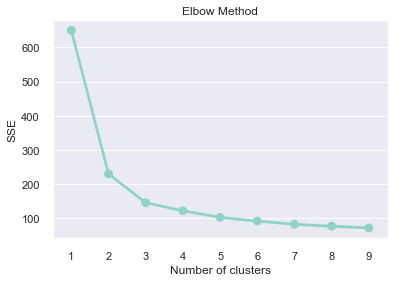

In [87]:
sse={}
for k in range(1,10):
    kmeans=KMeans(n_clusters=k,max_iter=100).fit(df_normalized_min_max)
    sse[k]=kmeans.inertia_
sb.pointplot(list(sse.keys()),list(sse.values()))
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')

In [88]:
sse

{1: 650.0015002241445,
 2: 230.12498539607958,
 3: 145.83405809978046,
 4: 122.21499290636785,
 5: 102.88897368894882,
 6: 92.06361079952362,
 7: 82.65918991086237,
 8: 77.11178339610933,
 9: 72.12833993525055}

Metoda lakta pokazuje da se najveće odstupanje tj. najveća greška formira kada je broj klastera dva, ali blagi nagib je formiran i gde je broj klastera tri, tako da se ne može sa sigurnošću tvrditi optimalan broj klastera. Da bi videli razliku u modelima kada je broj klastera dva ili tri, za ovaj slučaj ćemo uzeti tri.

### Silhouette metoda MMN

Text(0.5, 1.0, 'Silhouette method')

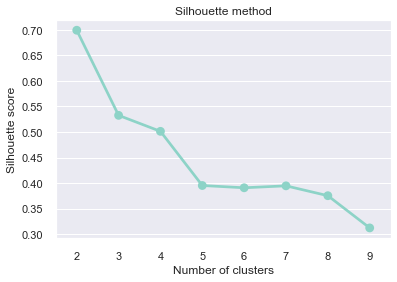

In [89]:
sb.set_palette('Set3')
sil={}
for k in range(2,10):
    kmeans=KMeans(n_clusters=k,max_iter=100).fit(df_normalized_min_max)
    labels=kmeans.predict(df_normalized_min_max)
    sil[k]=silhouette_score(df_normalized_min_max,labels)
sb.pointplot(list(sil.keys()),list(sil.values()))
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette method')

In [90]:
sil

{2: 0.6990037136424772,
 3: 0.5324932687424638,
 4: 0.5012061750103913,
 5: 0.3952478937662432,
 6: 0.39080962588242174,
 7: 0.3946076102959779,
 8: 0.3752983593265834,
 9: 0.3122666612741793}

Metoda siluete jasno pokazuje da je najbolja vrednost za broj klastera dva, jer u ovom slučaju se formira najviša vrednost siluet skora.

### Kreiranje modela gde je optimalan broj klastera tri MMN

In [99]:
cluster_model=KMeans(n_clusters=3,max_iter=100).fit(df_normalized_min_max)
centers=cluster_model.cluster_centers_
labels=cluster_model.predict(df_normalized_min_max)
df_normalized_min_max['Cluster']=labels
df_normalized_min_max.head()

,num_dist_account,choice_type,expenditure_type,income_type,account_transfer_operation,card_operation,choice_operation,deposit_operation,operation_unknown,transfer_from_account_operation,Cluster
0,0.0,0.0,0.035848,0.029267,0.086932,0.000000,0.014681,0.006638,0.092749,0.043357,0
2,1.0,0.0,0.045270,0.045461,0.120687,0.000000,0.016319,0.000312,0.130281,0.074409,1
3,0.0,0.0,0.059639,0.055259,0.164715,0.000000,0.020334,0.000182,0.199642,0.089073,0
4,0.0,0.0,0.111941,0.103181,0.086506,0.038337,0.082424,0.162327,0.196447,0.000000,0
5,0.0,0.0,0.163554,0.147687,0.283298,0.000000,0.090045,0.230351,0.232294,0.000000,2


Vizuelni prikaz sva tri formirana klstera se može videti na slici ispod.

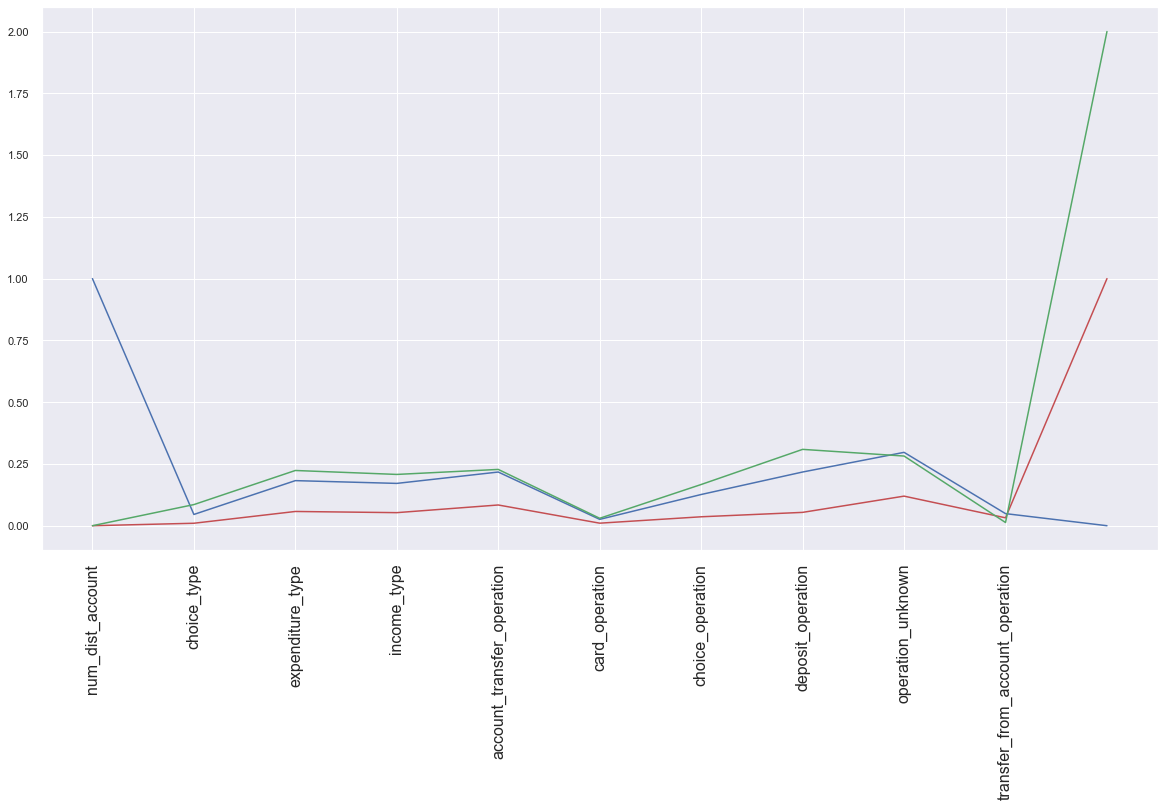

In [100]:
plt.close()
plt.figure(figsize=(20,10))
plt.plot(centers[0,:], c = 'r')
plt.plot(centers[1,:], c = 'b')
plt.plot(centers[2,:], c = 'g')
plt.xticks(list(range(10)), df_normalized_min_max.columns[:-1],rotation='vertical',size=16)
plt.show()

In [101]:
df_den_min_max=df[df_indeksi]
df_den_min_max['Cluster']=labels
df_den_min_max.iloc[:,1:].groupby('Cluster').agg(['mean']).round(3).T.unstack()

Cluster,0,1,2
,mean,mean,mean
num_dist_account,1.000,2.000,1.000
choice_type,7858.774,35836.654,67248.237
expenditure_type,290089.253,914827.446,1120329.044
income_type,333654.645,1031796.697,1246008.370
account_transfer_operation,94662.864,245111.404,257056.892
card_operation,1580.032,3958.650,4630.756
choice_operation,201705.130,701594.046,925889.633
deposit_operation,207624.878,835148.930,1187210.066
operation_unknown,3956.932,9814.320,9320.019


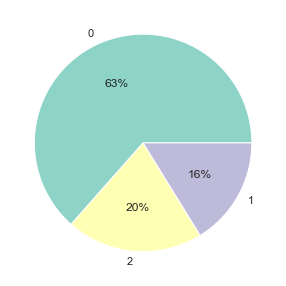

In [102]:
plt.figure(figsize=(10,5))
plt.pie(df_den_min_max['Cluster'].value_counts(),
        labels=df_den_min_max['Cluster'].value_counts().index,
        autopct='%.0f%%')
plt.show()

Može se uočiti da najveći broj klijenata pripada nultom klasteru. Ostala dva klastera su približno iste veličine.

Tumačenje centroida klastera i njihovih vrednosti je lakše tumačiti na osnovu onih podataka koji nisu normalizovani.

### Interpretacija dobijenih klastera za broj klastera tri MMN

**Klaster 0 (Low spenders)**: Po svim atributa ova grupa klijenata ima najmanje vrednosti. Ovo su klijenti koji imaju manje interakcija sa bankom, tj. kod kojih je zabeležen mali broj transakcija. U transakcijama koje su izvršili, koriste isključivo jedan račun. Ovi klijenti nemaju velike prihode, ali nemaju ni velike rashode. Ukupni prihodi su veći od ukupnih rashoda, pa može se reći da se radi o skupu klijenata koji zna da raspolaže sa novčanim sredstvima u bilo kom pogledu. Najmanja potrošnja se ostvaruje korišćenjem kreditne kartice i prenosa sredstava preko računa, pa se može reći da su ovi klijenti manje vešti u elektronskom obavljanju transakcija.

**Klaster 1 (E-spenders)**: Najveća razlika ove grupe klijenata u odnosu na druge dve grupe je što oni prilikom izvršavanja bankovnih transakcija koriste dva različita računa, dok ostale dve grupe isključivo jedan, što bi značilo da su više u svetu bankarstva. Druga razlika, ne toliko drastična kao prva, jeste što ovi klijenti imaju najveće prihode u pogledu pripisanih kamata. Ovi klijenti imaju veće rashode, ali i visoke prihode. Prilikom izvršavanja transakcija koriste kako kreditnu karticu tako i prenos sa računa, tako da se može reći da su ovi klijenti e- obučeni.

**Klaster 2 (Big spenders)**: Ova grupu čine klijenti koji su veliki potrošači ali ujedno sa visokim prihodima. Priliv novca se obavlja putem različitih bankovnih tipova i operacija, a najviše preko depozita koji im se isplaćuje. Ne vrše često transfer novca sa računa, ali visoke rahode ostvaruju plaćanjem direktno sa računa. Takođe, svi klijenti u ovom klasteru poseduju jedan račun, odnosno transakcije su izvršavali sa jednom računa.

### Kreiranje modela gde je optimalan broj klastera 2 MMN

In [103]:
cluster_model=KMeans(n_clusters=2,max_iter=100).fit(df_normalized_min_max.iloc[:,:-1])
centers=cluster_model.cluster_centers_
labels=cluster_model.predict(df_normalized_min_max.iloc[:,:-1])
df_normalized_min_max['Cluster']=labels
df_normalized_min_max.head()

,num_dist_account,choice_type,expenditure_type,income_type,account_transfer_operation,card_operation,choice_operation,deposit_operation,operation_unknown,transfer_from_account_operation,Cluster
0,0.0,0.0,0.035848,0.029267,0.086932,0.000000,0.014681,0.006638,0.092749,0.043357,1
2,1.0,0.0,0.045270,0.045461,0.120687,0.000000,0.016319,0.000312,0.130281,0.074409,0
3,0.0,0.0,0.059639,0.055259,0.164715,0.000000,0.020334,0.000182,0.199642,0.089073,1
4,0.0,0.0,0.111941,0.103181,0.086506,0.038337,0.082424,0.162327,0.196447,0.000000,1
5,0.0,0.0,0.163554,0.147687,0.283298,0.000000,0.090045,0.230351,0.232294,0.000000,1


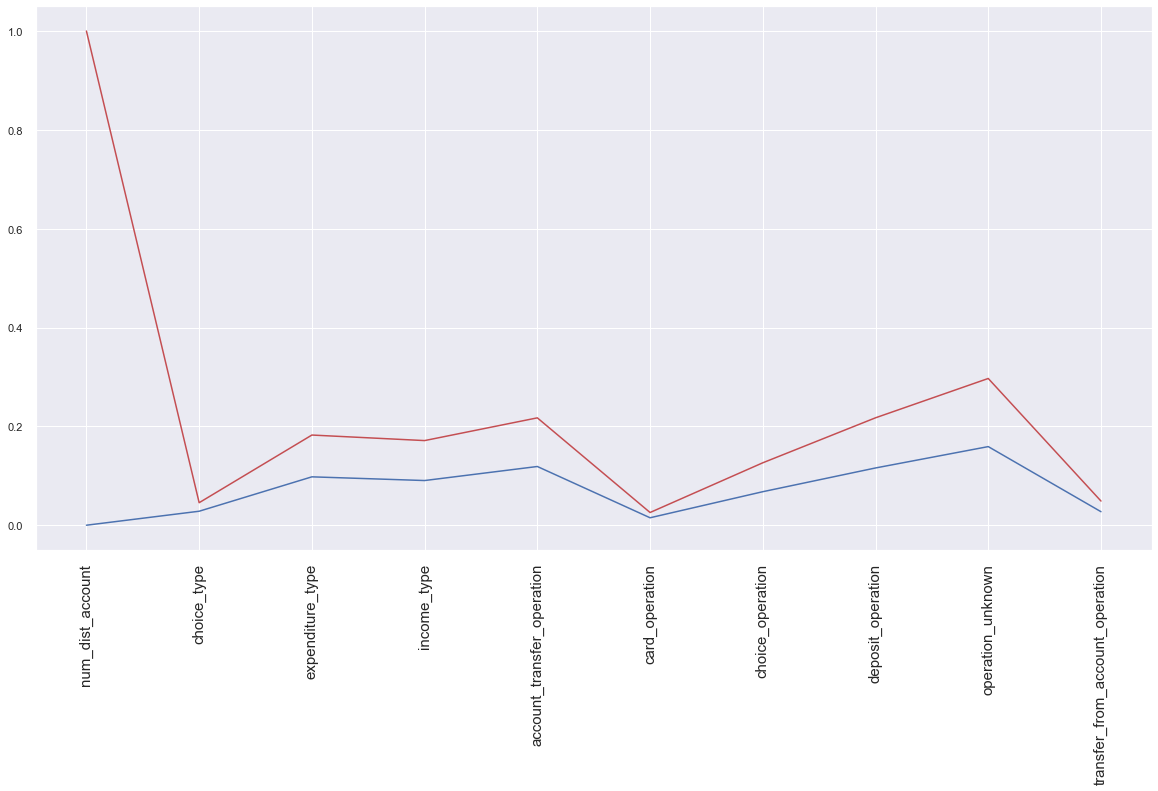

In [104]:
plt.close()
plt.figure(figsize=(20,10))
plt.plot(centers[0,:], c = 'r')
plt.plot(centers[1,:], c = 'b')
plt.xticks(list(range(10)), df_normalized_min_max.columns[:-1],rotation='vertical',size=15)
plt.show()

In [105]:
df_den_min_max_2=df[df_indeksi]
df_den_min_max_2['Cluster']=labels
df_den_min_max_2.iloc[:,1:].groupby('Cluster').agg(['mean']).round(3).T.unstack()

Cluster,0,1
,mean,mean
num_dist_account,2.000,1.000
choice_type,35836.654,22264.290
expenditure_type,914827.446,491472.325
income_type,1031796.697,554955.284
account_transfer_operation,245111.404,134053.181
card_operation,3958.650,2320.016
choice_operation,701594.046,377363.417
deposit_operation,835148.930,445233.189
operation_unknown,9814.320,5257.803


Broj klijenata koji pripada klasteru 1 je dosta veći u odnosu na drugi kreirani klaster.

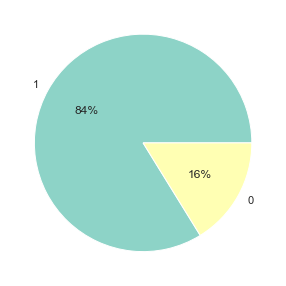

In [106]:
plt.figure(figsize=(10,5))
plt.pie(df_den_min_max_2['Cluster'].value_counts(),
        labels=df_den_min_max_2['Cluster'].value_counts().index,
        autopct='%.0f%%')
plt.show()

**Klaster 0 (Big spenders)**: Najveća razlika ove grupe klijenata u odnosu na na prvu grupu je što oni prilikom izvršavanja bankovnih transakcija koriste dva različita računa, dok prva grupa isključivo jedan, a što bi značilo da su više u svetu bankarstva. Još jedna razlika jeste što ovi klijenti imaju najveće prihode u pogledu pripisanih kamata. Ovi klijenti imaju veće rashode, ali i visoke prihode. Prilikom izvršavanja transakcija koriste kako kreditnu karticu tako i prenos sa računa, tako da se može reći da su ovi klijenti e- obučeni.

**Klaster 1 (Low spenders)**: Po svim atributa ova grupa klijenata ima najmanje vrednosti. Ovo su klijenti koji imaju manje interakcija sa bankom, tj. kod kojih je zabeležen mali broj transakcija. U transakcijama koje su izvršili, koriste isključivo jedan račun. Ovi klijenti nemaju velike prihode, ali nemaju ni velike rashode. Ukupni prihodi su veći od ukupnih rashoda, pa može se reći da se radi o skupu klijenata koji dobro raspolaže sa novčanim sredstvima u bilo kom pogledu. Najmanja potrošnja se ostvaruje korišćenjem kreditne kartice i prenosa sredstava preko računa, pa se može reći da su ovi klijenti manje vešti u elektronskom obavljanju transakcija.


Na sledećem prikazu se mogu videti oba klastera kao i prosečna vrednost siluet skora koja iznosi 0.69. Ova vrednost, kao i nepostojanje negativnih ili jako niskih vrednosti ukazuje na dobro raspoređene klijente po grupama.Takođe, jasno je primetno da je nulti klaster dosta veći od prvog.

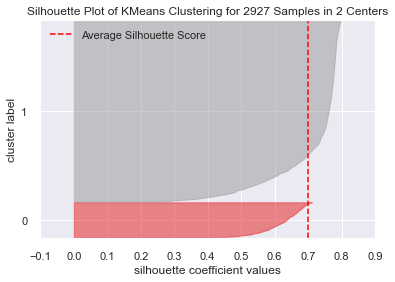

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2927 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [107]:
model=SilhouetteVisualizer(cluster_model)
model.fit(df_normalized_min_max.iloc[:,:-1])
model.show()

## Normalizacija podataka upotrebom *StandardScaler*-a

Pored MinMax normalizacije koja je prethodno opisana, sada će biti prikazana i detaljna analiza kada se za normalizaciju podataka koristi StandardScaler metoda.

In [108]:
df_normalized_standard_scaler= StandardScaler().fit_transform(df.iloc[:,1:])
df_normalized_standard_scaler=pd.DataFrame(df_normalized_standard_scaler,columns=df.columns[1:])
df_normalized_standard_scaler.head()

,num_dist_account,choice_type,expenditure_type,income_type,account_transfer_operation,card_operation,choice_operation,deposit_operation,operation_unknown,transfer_from_account_operation
0,-0.471938,-0.419541,-0.793265,-0.809285,-0.426097,-0.332896,-0.752323,-0.820255,-0.790590,-0.033783
1,2.118922,1.729299,1.208871,1.364879,2.601925,-0.332896,0.806575,-0.540375,1.227930,3.037733
2,2.118922,-0.419541,-0.719376,-0.677507,-0.204401,-0.332896,-0.737804,-0.855368,-0.533032,0.231588
3,-0.471938,-0.419541,-0.606701,-0.597777,0.084763,-0.332896,-0.702237,-0.856090,-0.057054,0.356908
4,-0.471938,-0.419541,-0.196556,-0.207796,-0.428892,0.064903,-0.152176,0.043961,-0.078980,-0.404310


Izbacivanje izuzetaka.

In [109]:
z=np.abs(stats.zscore(df_normalized_standard_scaler))
print(len(np.where(z>3)[0]), ' ', len(set(np.where(z>3)[0])))
df_indeksi=(z<3).all(axis=1)
df_normalized_standard_scaler=df_normalized_standard_scaler[df_indeksi]
df_normalized_standard_scaler.head()

628   312


,num_dist_account,choice_type,expenditure_type,income_type,account_transfer_operation,card_operation,choice_operation,deposit_operation,operation_unknown,transfer_from_account_operation
0,-0.471938,-0.419541,-0.793265,-0.809285,-0.426097,-0.332896,-0.752323,-0.820255,-0.790590,-0.033783
2,2.118922,-0.419541,-0.719376,-0.677507,-0.204401,-0.332896,-0.737804,-0.855368,-0.533032,0.231588
3,-0.471938,-0.419541,-0.606701,-0.597777,0.084763,-0.332896,-0.702237,-0.856090,-0.057054,0.356908
4,-0.471938,-0.419541,-0.196556,-0.207796,-0.428892,0.064903,-0.152176,0.043961,-0.078980,-0.404310
5,-0.471938,-0.419541,0.208186,0.154374,0.863587,-0.332896,-0.084658,0.421552,0.167013,-0.404310


Ukupan broj izuzetaka je 628, a izbacuje se 312 vrednosti.

## Određivanje optimalnog broja klastera SSN

Kada su podaci normalizovani i kada su izbačeni izuzeci, potrebno je odrediti optimalan broj klastera za primenu k-means algoritma.

### Metoda lakta SSN

Text(0.5, 1.0, 'Elbow Method')

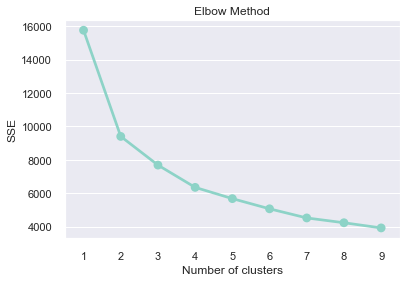

In [110]:
sse={}
for k in range(1,10):
    kmeans=KMeans(n_clusters=k,max_iter=100).fit(df_normalized_standard_scaler)
    sse[k]=kmeans.inertia_
sb.pointplot(list(sse.keys()),list(sse.values()))
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')

In [111]:
sse

{1: 15757.407878290229,
 2: 9399.69096852891,
 3: 7683.102127017696,
 4: 6349.0260517915585,
 5: 5675.399603964435,
 6: 5065.191312609,
 7: 4518.578153282488,
 8: 4230.721488353571,
 9: 3921.2970957260054}

Metoda lakta pokazuje da se najveće odstupanje tj. najveća greška formira kada je broj klastera dva, tako da će model biti kreiran sa k=2.

### Silhouette metoda SSN

Text(0.5, 1.0, 'Silhouette method')

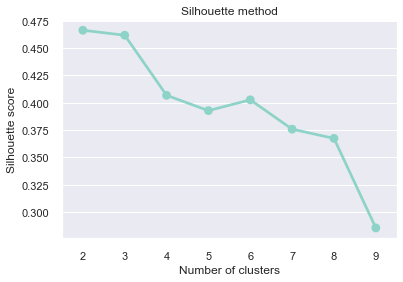

In [112]:
sb.set_palette('Set3')
sil={}
for k in range(2,10):
    kmeans=KMeans(n_clusters=k,max_iter=100).fit(df_normalized_standard_scaler)
    labels=kmeans.predict(df_normalized_standard_scaler)
    sil[k]=silhouette_score(df_normalized_standard_scaler,labels)
sb.pointplot(list(sil.keys()),list(sil.values()))
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette method')

In [113]:
sil

{2: 0.4662460664591627,
 3: 0.46168716118325104,
 4: 0.4067797028146694,
 5: 0.39279428901306707,
 6: 0.40266474163989757,
 7: 0.37584555877704806,
 8: 0.3674125292486991,
 9: 0.28559250825473426}

Metoda siluete jasno pokazuje da je najbolja vrednost za broj klastera dva, jer u ovom slučaju se formira najviša vrednost siluet skora.

Zaključak je da obe metode za određivanje optimalnog broja klastera pokazuju da je najbolja vrednost za broj klastera dva, tako da će model biti kreiran samo sa ovim brojem klastera, odnosno neće biti potrebe za formiranjem dva zasebna modela.

### Kreiranje modela gde je optimalan broj klastera dva SSN

In [114]:
cluster_model=KMeans(n_clusters=2,max_iter=100).fit(df_normalized_standard_scaler)
centers=cluster_model.cluster_centers_
labels=cluster_model.predict(df_normalized_standard_scaler)
df_normalized_standard_scaler['Cluster']=labels
df_normalized_standard_scaler.head()

,num_dist_account,choice_type,expenditure_type,income_type,account_transfer_operation,card_operation,choice_operation,deposit_operation,operation_unknown,transfer_from_account_operation,Cluster
0,-0.471938,-0.419541,-0.793265,-0.809285,-0.426097,-0.332896,-0.752323,-0.820255,-0.790590,-0.033783,0
2,2.118922,-0.419541,-0.719376,-0.677507,-0.204401,-0.332896,-0.737804,-0.855368,-0.533032,0.231588,0
3,-0.471938,-0.419541,-0.606701,-0.597777,0.084763,-0.332896,-0.702237,-0.856090,-0.057054,0.356908,0
4,-0.471938,-0.419541,-0.196556,-0.207796,-0.428892,0.064903,-0.152176,0.043961,-0.078980,-0.404310,0
5,-0.471938,-0.419541,0.208186,0.154374,0.863587,-0.332896,-0.084658,0.421552,0.167013,-0.404310,1


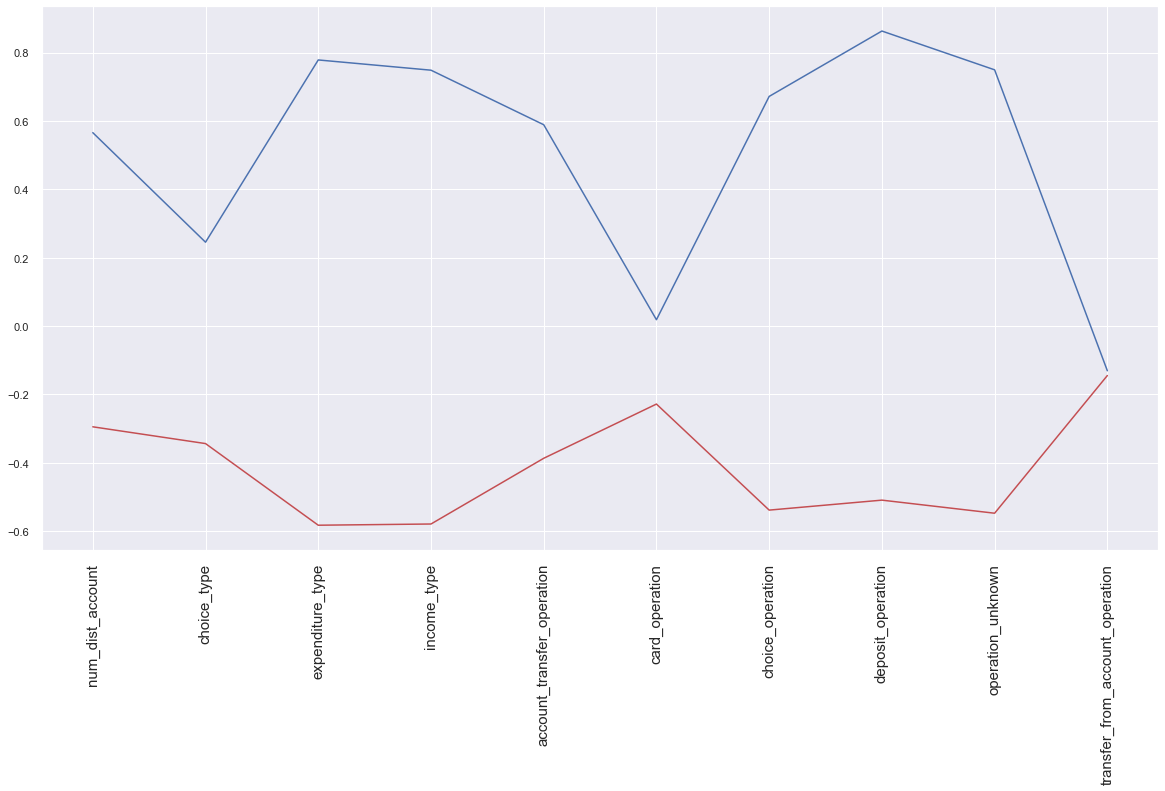

In [115]:
plt.close()
plt.figure(figsize=(20,10))
plt.plot(centers[0,:], c = 'r')
plt.plot(centers[1,:], c = 'b')
plt.xticks(list(range(10)), df_normalized_standard_scaler.columns[:-1],rotation='vertical',size=15)
plt.show()

In [116]:
df_den=df[df_indeksi]
df_den['Cluster']=labels

In [117]:
df_den.iloc[:,1:].groupby('Cluster').agg(['mean']).round(3).T.unstack()

Cluster,0,1
,mean,mean
num_dist_account,1.069,1.400
choice_type,7682.459,67359.640
expenditure_type,315602.444,1184911.641
income_type,361487.217,1324189.357
account_transfer_operation,104938.940,272446.814
card_operation,1554.800,5220.049
choice_operation,216791.162,974604.419
deposit_operation,241159.894,1191515.419
operation_unknown,4240.042,10483.998


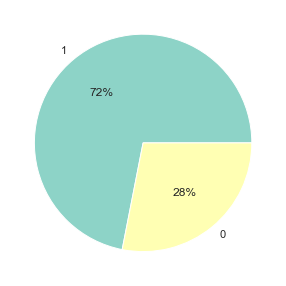

In [177]:
plt.figure(figsize=(10,5))
plt.pie(df_den['Cluster'].value_counts(),
        labels=df_den['Cluster'].value_counts().index,
        autopct='%.0f%%')
plt.show()

**Klaster 0 (Big spenders)**: Ova grupa klijenata u odnosu na prvu grupu najvećim delom izvršava transakcije korišćenjem dva različita računa. Još jedna razlika jeste što ovi klijenti imaju najveće prihode u pogledu pripisanih kamata i dobijenih depozita. Ovi klijenti imaju jako visoke rashode, ali i visoke prihode. Prilikom izvršavanja transakcija manje koriste  kreditnu karticu i prenos sa računa, ali vise on klijenata u Klasteru 1.

**Klaster 1 (Low spenders)**: Po svim atributa ova grupa klijenata ima najmanje vrednosti. Ovo su klijenti koji imaju manje interakcija sa bankom, tj. kod kojih je zabeležen mali broj transakcija. U transakcijama koje su izvršili, koriste u najvećem broju slučajeva jedan račun. Ovi klijenti nemaju velike prihode, ali nemaju ni velike rashode. Ukupni prihodi su veći od ukupnih rashoda, pa može se reći da se radi o skupu klijenata koji dobro raspolaže sa novčanim sredstvima u bilo kom pogledu. Najveća potrošnja se ostvaruje korišćenjem kreditne kartice i prenosa sredstava preko računa, pa se može reći da su ovi klijenti više vešti u elektronskom obavljanju transakcija.

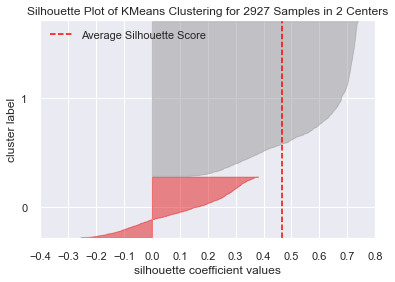

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2927 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [179]:
model=SilhouetteVisualizer(cluster_model)
model.fit(df_normalized_standard_scaler.iloc[:,:-1])
model.show()

Na prethodnom prikazu se mogu videti oba dobijena klastera kao i prosečna vrednost siluet skora koja iznosi 0.47. Može se videti disbalans u broju klijenata u nultom i prvom klasteru, a ono što je još bitnije je postojanje negativnih vrednosti kod nultnog klastera, što ukazuje na to da su ovi klijenti pogrešno raspoređeni i da ih treba premestiti u prvi klaster, čime bi se on dodatno povećao za taj broj.

# Hijerarhisjko aglomerativno klasterovanje

Pored klasterovanja upotrebom k-means algoritma, ovde će biti prikazano i hijerahijsko aglomerativno klasterovanje.

Koriste se podaci koji su normalizovani putem minmaxscaler-a i iz kojih su izbačeni izuzeci.

In [180]:
df_normalized_min_max.drop(columns=['Cluster'],axis=1,inplace=True)
df_normalized_min_max.head()

,num_dist_account,choice_type,expenditure_type,income_type,account_transfer_operation,card_operation,choice_operation,deposit_operation,operation_unknown,transfer_from_account_operation
0,0.0,0.0,0.035848,0.029267,0.086932,0.000000,0.014681,0.006638,0.092749,0.043357
2,1.0,0.0,0.045270,0.045461,0.120687,0.000000,0.016319,0.000312,0.130281,0.074409
3,0.0,0.0,0.059639,0.055259,0.164715,0.000000,0.020334,0.000182,0.199642,0.089073
4,0.0,0.0,0.111941,0.103181,0.086506,0.038337,0.082424,0.162327,0.196447,0.000000
5,0.0,0.0,0.163554,0.147687,0.283298,0.000000,0.090045,0.230351,0.232294,0.000000


Za računanje udaljenosti se koristi ward tip koji minimizuje varijansu.

In [181]:
Z=linkage(df_normalized_min_max,'ward')

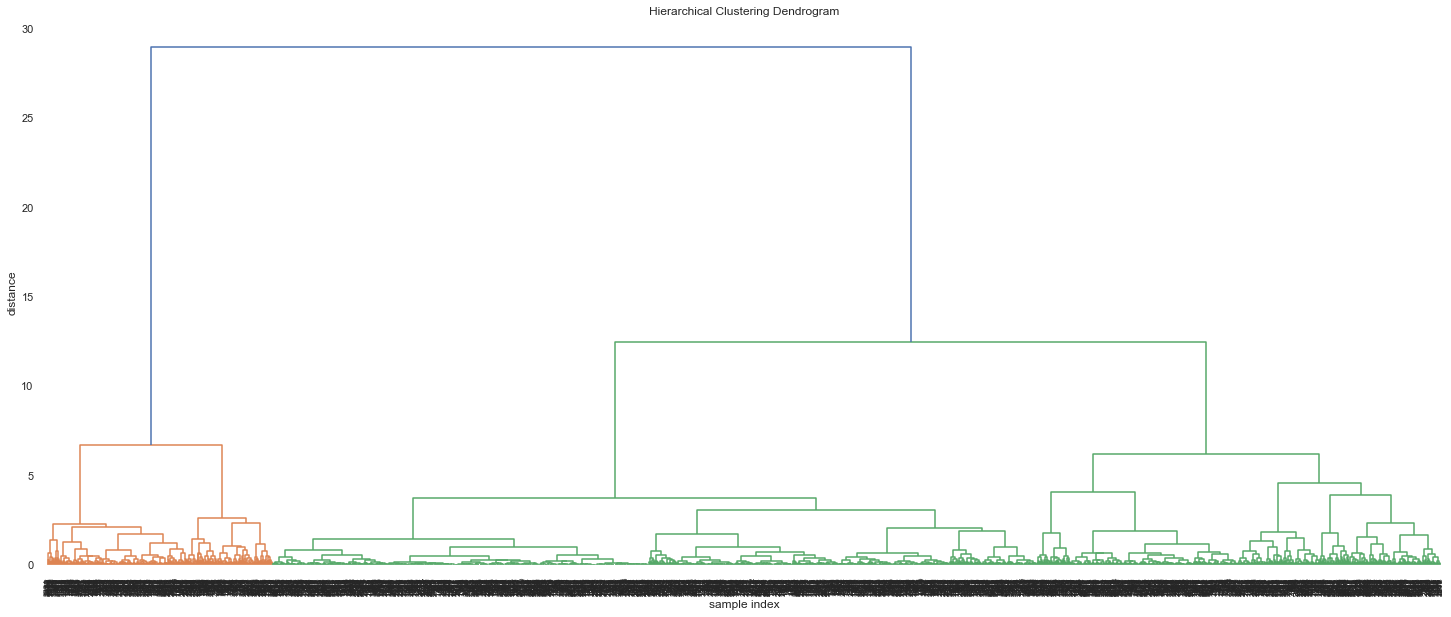

In [1121]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,
    leaf_font_size=8.,
    
)
plt.show()

Već preko dendrograma se može zaključiti da je je najbolje uzeti dva klastera kao optimalan broj jer na se tu formira najveća udaljenost u odnosu na sledeće podtipove dendrograma. 

## Određivanje optimalnog broja klastera za hijerarhijsko klasterovanje

### Silhouette metoda hijerarhijsko klasterovanje

Text(0.5, 1.0, 'Silhouette method')

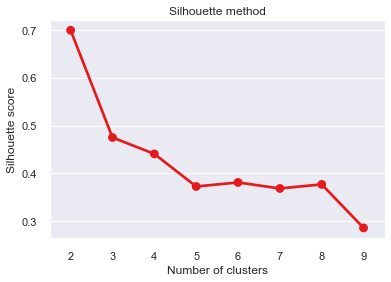

In [183]:
sb.set_palette('Set1')
sil={}
for k in range(2,10):
    clustering_help = AgglomerativeClustering(linkage='ward', n_clusters=k)
    clustering_help.fit(df_normalized_min_max)
    sil[k]=silhouette_score(X=df_normalized_min_max,labels=clustering_help.labels_)
sb.pointplot(list(sil.keys()),list(sil.values()))
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette method') 

In [184]:
sil

{2: 0.6990037136424772,
 3: 0.4750347658794026,
 4: 0.4407100386210291,
 5: 0.3726741417668996,
 6: 0.3810661857773842,
 7: 0.3685231016988887,
 8: 0.3770363446585914,
 9: 0.2861072592519283}

In [ ]:
clustering = AgglomerativeClustering(linkage='ward', n_clusters=2)
clustering.fit(df_normalized_min_max)
df_hije=df_normalized_min_max.copy()
df_hije['Cluster']=clustering.labels_

In [196]:
centres_hije_0=df_hije[df_hije['Cluster']==0].mean()
centres_hije_1=df_hije[df_hije['Cluster']==1].mean()

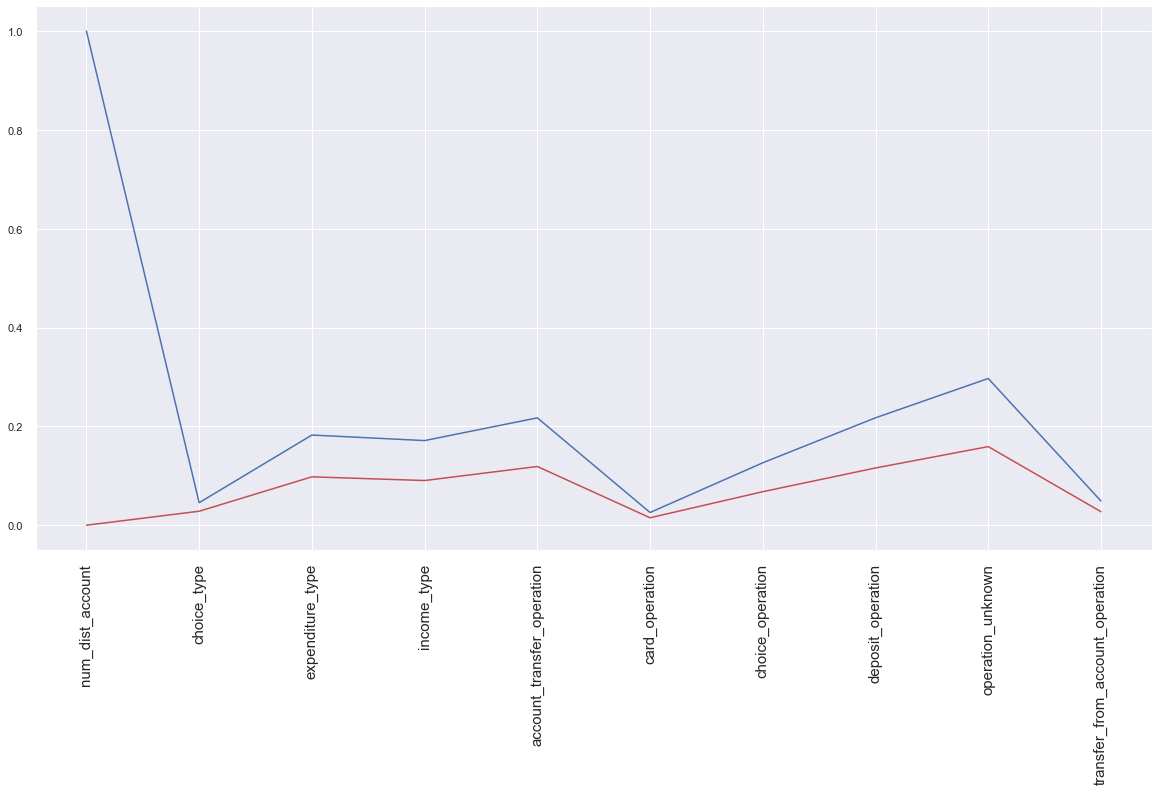

In [197]:
plt.close()
plt.figure(figsize=(20,10))
plt.plot(centres_hije_0[:-1], c = 'r')
plt.plot(centres_hije_1[:-1], c = 'b')
plt.xticks(list(range(10)), df_hije.columns[:-1],rotation='vertical', size=15)
plt.show()


In [193]:
df_hije.groupby('Cluster').agg(['mean']).round(3).T.unstack()

Cluster,0,1
,mean,mean
num_dist_account,0.000,1.000
choice_type,0.028,0.046
expenditure_type,0.098,0.182
income_type,0.090,0.171
account_transfer_operation,0.119,0.217
card_operation,0.015,0.026
choice_operation,0.068,0.126
deposit_operation,0.116,0.217
operation_unknown,0.159,0.297


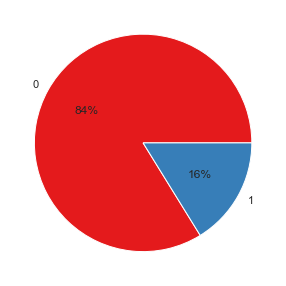

In [194]:
plt.figure(figsize=(10,5))
plt.pie(df_hije['Cluster'].value_counts(),
        labels=df_hije['Cluster'].value_counts().index,
        autopct='%.0f%%')
plt.show()

**Klaster 0 (Low spenders)**: Po svim atributa ova grupa klijenata ima najmanje vrednosti. Ovo su klijenti koji imaju manje interakcija sa bankom, tj. kod kojih je zabeležen mali broj transakcija. Ovi klijenti nemaju velike prihode, ali nemaju ni velike rashode. Ukupni prihodi su veći od ukupnih rashoda, pa može se reći da se radi o skupu klijenata koji dobro raspolaže sa novčanim sredstvima u bilo kom pogledu. Prilikom izvršavanja transakcija najmanje koriste  kreditnu karticu i prenos sa računa, tako da se može reći da ovi klijenti nisu previše vešti u e-transakcijama.

**Klaster 1 (Big spenders)**: Ova grupa klijenata ima najveće prihode u pogledu pripisanih kamata i dobijenih depozita. Ovi klijenti imaju visoke rashode, ali i visoke prihode. Prilikom izvršavanja transakcija najmanje koriste  kreditnu karticu i prenos sa računa.

### Korelaciona matrica

In [195]:
corr=df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,client_id,num_dist_account,choice_type,expenditure_type,income_type,account_transfer_operation,card_operation,choice_operation,deposit_operation,operation_unknown,transfer_from_account_operation
client_id,1.00,-0.05,0.08,0.07,0.07,0.01,-0.01,0.08,0.07,0.03,0.01
num_dist_account,-0.05,1.00,0.10,0.33,0.33,0.31,0.09,0.27,0.29,0.45,0.08
choice_type,0.08,0.10,1.00,0.64,0.71,0.16,0.09,0.76,0.44,0.43,0.47
expenditure_type,0.07,0.33,0.64,1.00,0.99,0.58,0.31,0.96,0.81,0.84,0.34
income_type,0.07,0.33,0.71,0.99,1.00,0.55,0.30,0.97,0.80,0.83,0.37
account_transfer_operation,0.01,0.31,0.16,0.58,0.55,1.00,0.12,0.34,0.44,0.54,0.20
card_operation,-0.01,0.09,0.09,0.31,0.30,0.12,1.00,0.28,0.28,0.39,0.06
choice_operation,0.08,0.27,0.76,0.96,0.97,0.34,0.28,1.00,0.78,0.77,0.37
deposit_operation,0.07,0.29,0.44,0.81,0.80,0.44,0.28,0.78,1.00,0.70,-0.26
operation_unknown,0.03,0.45,0.43,0.84,0.83,0.54,0.39,0.77,0.70,1.00,0.25


Kao što se može videti, između pojedinih atributa ovog skupa se javlja jako visoka korelacija. To je zato što operacije koje se vrše putem transakcija su zapravo modovi tipova transakcija, odnosno za svaki tip postoje određene transakcije. U detaljnijem razmatranju ovog modela treba uzeti u obzir i ovaj zaključak kako bi se dobila validna rešenja. Jedan od načina je da se izbace tipovi transakcija i ostave samo operacije, a koje će ujedno da ukazuju i na tip.